In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
from PIL import Image
import nltk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,InputLayer,Bidirectional, LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy,Precision,Recall
from tensorflow.keras.optimizers import Adam

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
# Loading the IMDB review dataset
train_ds, val_ds, test_ds = tfds.load('imdb_reviews',
                                      split=['train', 'test[:50%]', 'test[50%:]'],
                                      as_supervised=True,
                                      with_info=False)

In [7]:
# Getting the dataset information
dataset_info = tfds.load('imdb_reviews', with_info=True)

In [8]:
# Print dataset information
print(dataset_info)

({'train': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>, 'test': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>, 'unsupervised': <_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>}, tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stan

In [9]:
# Explore the training dataset
print("Training Dataset:")
for example in train_ds.take(1):
    print(example)

Training Dataset:
(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [10]:
# Converting the dataset to a Pandas DataFrame for easier exploration
def tfds_to_dataframe(ds):
    data = []
    for example in ds:
        data.append({'text': example[0].numpy().decode('utf-8'),
                     'label': example[1].numpy()})
    return pd.DataFrame(data)

In [11]:
train_df = tfds_to_dataframe(train_ds)
val_df = tfds_to_dataframe(val_ds)
test_df = tfds_to_dataframe(test_ds)

In [12]:
# Define labels
train_labels = train_df['label']
val_labels = val_df['label']
test_labels = test_df['label']

In [13]:
train_df.head(7)

,text,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1
5,This is a film which should be seen by anybody...,1
6,"Okay, you have:<br /><br />Penelope Keith as M...",0


In [14]:
# View label distribution
print("Label Distribution:")
print(train_df['label'].value_counts())

Label Distribution:
label
0    12500
1    12500
Name: count, dtype: int64


In [15]:
train_df.isnull().sum()

,0
text,0
label,0


In [16]:
# View text length distribution
print("Text Length Distribution:")
print(train_df['text'].apply(len).describe())

Text Length Distribution:
count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: text, dtype: float64


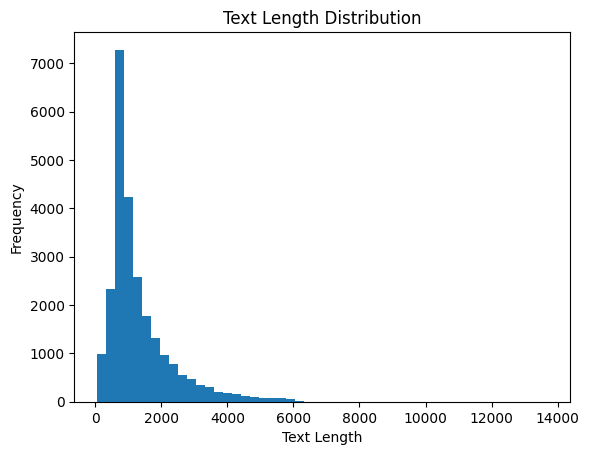

In [17]:
# Plot text length distribution
plt.hist(train_df['text'].apply(len), bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

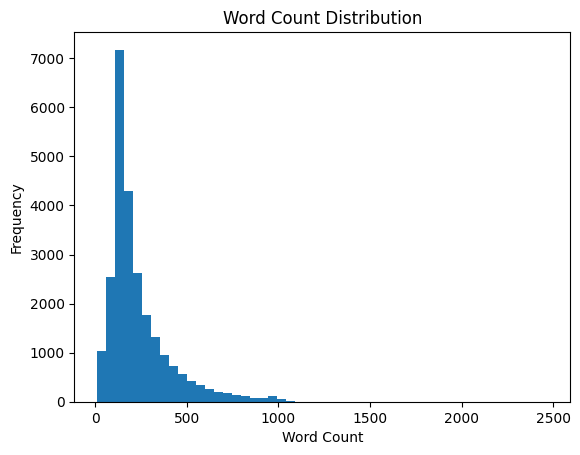

In [18]:
# Plot word count
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
plt.hist(train_df['word_count'], bins=50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

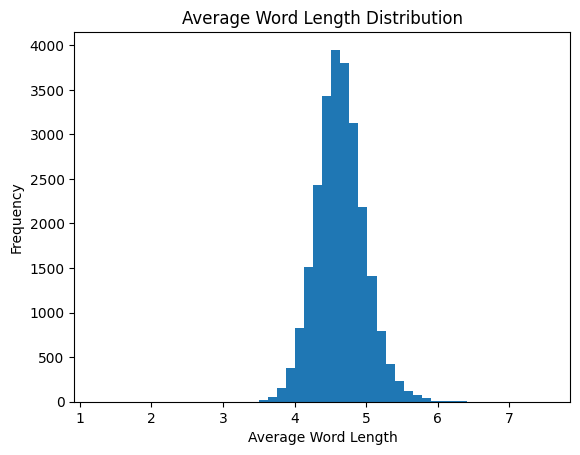

In [19]:
# Average Word Length Distribution
train_df['avg_word_len'] = train_df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
plt.hist(train_df['avg_word_len'], bins=50)
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.title('Average Word Length Distribution')
plt.show()

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [21]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

In [24]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

train_tokens = train_df['text'].apply(preprocess_text)
val_tokens = val_df['text'].apply(preprocess_text)
test_tokens = test_df['text'].apply(preprocess_text)

In [27]:
from collections import Counter
train_token_freq = Counter([token for tokens in train_tokens for token in tokens])
val_token_freq = Counter([token for tokens in val_tokens for token in tokens])
test_token_freq = Counter([token for tokens in test_tokens for token in tokens])

print("Top 10 most frequent tokens in training set:")
print(train_token_freq.most_common(10))

print("\nTop 10 most frequent tokens in validation set:")
print(val_token_freq.most_common(10))

print("\nTop 10 most frequent tokens in testing set:")
print(test_token_freq.most_common(10))

Top 10 most frequent tokens in training set:
[('movie', 49579), ('film', 45189), ('one', 26313), ('like', 20025), ('time', 14874), ('good', 14562), ('character', 13797), ('story', 12621), ('get', 12413), ('even', 12326)]

Top 10 most frequent tokens in validation set:
[('movie', 24084), ('film', 22142), ('one', 13095), ('like', 9717), ('time', 7126), ('good', 7055), ('character', 6790), ('get', 6005), ('see', 5931), ('would', 5885)]

Top 10 most frequent tokens in testing set:
[('movie', 25277), ('film', 22423), ('one', 13241), ('like', 10039), ('time', 7356), ('character', 6983), ('good', 6979), ('even', 6128), ('get', 6015), ('would', 5992)]


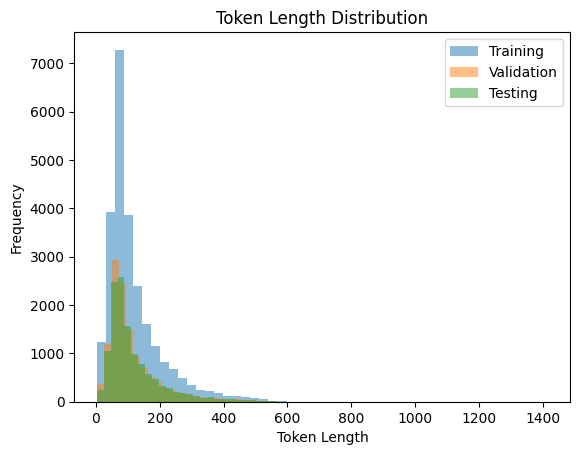

In [28]:
train_token_lengths = [len(tokens) for tokens in train_tokens]
val_token_lengths = [len(tokens) for tokens in val_tokens]
test_token_lengths = [len(tokens) for tokens in test_tokens]

plt.hist(train_token_lengths, bins=50, alpha=0.5, label='Training')
plt.hist(val_token_lengths, bins=50, alpha=0.5, label='Validation')
plt.hist(test_token_lengths, bins=50, alpha=0.5, label='Testing')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

In [29]:
# Average token length
print("Average token length in training set:", sum(train_token_lengths) / len(train_token_lengths))
print("Average token length in validation set:", sum(val_token_lengths) / len(val_token_lengths))
print("Average token length in testing set:", sum(test_token_lengths) / len(test_token_lengths))

Average token length in training set: 119.73604
Average token length in validation set: 115.99864
Average token length in testing set: 118.02752


In [30]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>", "")
    output = tf.strings.regex_replace(no_tag, "[%s]" % re.escape(string.punctuation), "")

    return output

In [31]:
VOCAB_SIZE = 20000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 300


In [32]:
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)


In [33]:
training_data = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(training_data)

In [34]:
def vectorizer(review, label):
    return vectorize_layer(review), label

In [35]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)

In [36]:
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 300)            │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,232,321 (23.77 MB)

 Trainable params: 6,232,321 (23.77 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy', 'precision', 'recall', 'auc'])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [42]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 70ms/step - accuracy: 0.6732 - auc: 0.7383 - loss: 0.5806 - precision: 0.6668 - recall: 0.6990 - val_accuracy: 0.8314 - val_auc: 0.9119 - val_loss: 0.3913 - val_precision: 0.8607 - val_recall: 0.7880
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8871 - auc: 0.9434 - loss: 0.2982 - precision: 0.8885 - recall: 0.8855 - val_accuracy: 0.7870 - val_auc: 0.8716 - val_loss: 0.4521 - val_precision: 0.7750 - val_recall: 0.8048
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.9239 - auc: 0.9688 - loss: 0.2174 - precision: 0.9273 - recall: 0.9193 - val_accuracy: 0.8375 - val_auc: 0.9092 - val_loss: 0.5289 - val_precision: 0.8628 - val_recall: 0.8001
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9586 - auc: 0.9877 - loss: 0.1268 - precision: 0.9614 - recall: 0.9561 - val_accuracy: 0.8123 - val_auc: 0.8865 - val_loss: 0.5569 - val_precision: 0.8396 - val_recall: 0.7690


In [45]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8276 - auc: 0.9119 - loss: 0.3952 - precision: 0.8617 - recall: 0.7824


[0.3941609263420105,
 0.8297600150108337,
 0.863326907157898,
 0.7862024903297424,
 0.9120951890945435]

In [47]:
# Prediction
def sentiment_analysis(text):
    text = tf.convert_to_tensor([text])
    output = vectorize_layer(text)
    output = tf.squeeze(output)  # Remove extra dimension
    prediction = model.predict(tf.expand_dims(output, axis=0))
    sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
    confidence = prediction[0][0] * 100
    return sentiment, confidence

# Test sentences
test_sentences = [
    "I loved the movie!",
    "This movie is terrible.",
    "The movie was okay.",
    "I hated the ending.",
    "The acting was amazing!"
]

for sentence in test_sentences:
    sentiment, confidence = sentiment_analysis(sentence)
    print(f"Sentence: {sentence}")
    print(f"Sentiment: {sentiment}, Confidence: {confidence}%")
    print("------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Sentence: I loved the movie!
Sentiment: Positive, Confidence: 78.18787097930908%
------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sentence: This movie is terrible.
Sentiment: Negative, Confidence: 29.786741733551025%
------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sentence: The movie was okay.
Sentiment: Positive, Confidence: 50.440943241119385%
------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Sentence: I hated the ending.
Sentiment: Negative, Confidence: 36.083006858825684%
------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sentence: The acting was amazing!
Sentiment: Positive, Confidence: 69.66204047203064%
------------------------
